In [657]:
import h5py
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import corner
import scipy.special
%matplotlib inline

In [658]:
filename = "../data/pairs_box_L205n2500TNG.hdf5"
f = h5py.File(filename, 'r')
keys = list(f.keys())
pair_data = {}
for k in keys:
    pair_data[k] = f[k][...]
print(keys)
f.close()
print(pair_data['hubble'])

['halo_mass_A', 'halo_mass_B', 'halo_mass_G', 'hubble', 'pos_A', 'pos_B', 'pos_G', 'stellar_mass_A', 'stellar_mass_B', 'stellar_mass_G', 'vel_A', 'vel_B', 'vel_G', 'vmax_A', 'vmax_B', 'vmax_G']
0.6774


In [659]:
# sort
ii = pair_data['stellar_mass_A']>pair_data['stellar_mass_B']
for k in ['pos_A']:
    tmp = pair_data[k][ii]
    pair_data[k]

In [660]:
pair_data['vel_A_mag'] = np.sqrt(np.sum(pair_data['vel_A']**2, axis=1))
pair_data['vel_B_mag'] = np.sqrt(np.sum(pair_data['vel_B']**2, axis=1))
pair_data['vel_G_mag'] = np.sqrt(np.sum(pair_data['vel_G']**2, axis=1))

pair_data['pos_AB'] = np.sqrt(np.sum( (pair_data['pos_B'] - pair_data['pos_A'])**2, axis=1))
pair_data['vel_AB'] = np.sqrt(np.sum( (pair_data['vel_B'] - pair_data['vel_A'])**2, axis=1)) # comoving
pair_data['vel_AB_rad'] = np.sum((pair_data['pos_B'] - pair_data['pos_A'])*(pair_data['vel_B'] - pair_data['vel_A']), axis=1)/pair_data['pos_AB'] #comoving
pair_data['vel_AB_tan'] = np.sqrt((pair_data['vel_AB']**2 - pair_data['vel_AB_rad']**2))# comoving
    
#now we compute the radial velocity including the hubble flow, positions are in kpc
pair_data['vel_AB_rad'] = pair_data['vel_AB_rad'] + (pair_data['pos_AB']/1000 * pair_data['hubble']*100)

# here we compute the compute the dot product between the position vector and the radial velocity
pair_data['mu'] = np.abs(np.sum((pair_data['pos_B']-pair_data['pos_A'])*(pair_data['vel_B']), axis=1)/(pair_data['vel_B_mag']*pair_data['pos_AB']))

In [661]:
ii = pair_data['pos_AB']<10000
for k in pair_data.keys():
    if k!='hubble' and (not 'G' in k):
        pair_data[k] = pair_data[k][ii]

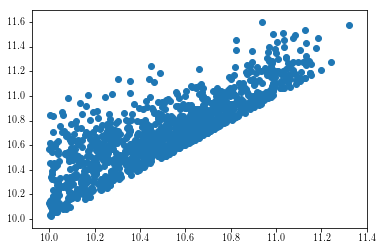

In [662]:
plt.scatter(np.log10(pair_data['stellar_mass_A']), np.log10(pair_data['stellar_mass_B']))

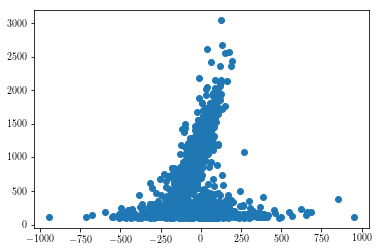

In [663]:
plt.scatter(pair_data['vel_AB_rad'], pair_data['pos_AB'])

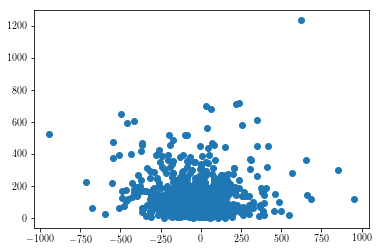

In [664]:
plt.scatter(pair_data['vel_AB_rad'], pair_data['vel_AB_tan'])

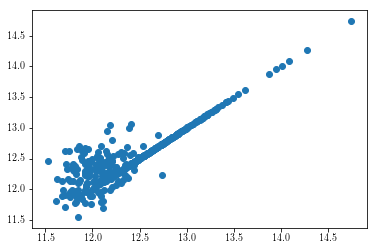

In [665]:
ii = (pair_data['vel_AB_rad']<0.0) & (pair_data['vel_AB_tan']<100)
plt.scatter(np.log10(pair_data['halo_mass_A'][ii]), np.log10(pair_data['halo_mass_B'][ii]))

In [697]:
def plot_corner_full(data, id_list=None, cut_name=None):
    local_data = data.copy()
    if id_list is not None:
        for k in data.keys():
            if k!='hubble' and (not 'G' in k):
                local_data[k] = data[k][id_list]

    print('n_points {}'.format(len(local_data['halo_mass_A'])))
    #print('unique n_points {}'.format(len(id_list)))

    local_data['log_halo_mass_A'] = np.log10(local_data['halo_mass_A'])
    local_data['log_halo_mass_B'] = np.log10(local_data['halo_mass_B'])
    local_data['log_stellar_mass_A'] = np.log10(local_data['stellar_mass_A'])
    local_data['log_stellar_mass_B'] = np.log10(local_data['stellar_mass_B'])
    local_data['log_distance'] = np.log10(local_data['pos_AB'])
    local_data['log_tan_vel'] = np.log10(local_data['vel_AB_tan'])
    local_data['log_radial_vel'] = local_data['vel_AB_rad']
    s = np.array([1.0,2.0,3.0])
    levels = 1-np.exp(-(s**2)/2.0)
    plt.figure(figsize=(8,5))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=20)
    cols = ['log_stellar_mass_A', 'log_stellar_mass_B', 'log_halo_mass_A', 'log_halo_mass_B','log_distance', 'log_radial_vel', 'log_tan_vel']
    array_data = np.ones((len(local_data[cols[0]]), len(cols)))
    for i,c in enumerate(cols):
        array_data[:,i] = local_data[c]
    
    truth = np.array([np.log10(5.0E10), np.log10(10.3E10), np.log10(1.5E12), np.log10(5E12), np.log10(780), -109.0, np.log10(57.3)])
    labels=[r"$\log_{10} M_{\star,A}$", r"$\log_{10} M_{\star,B}$", 
                        r"$\log_{10} M_{DM,A}$", r"$\log_{10} M_{DM,B}$",
                        r"$\log_{10} D$", r"$V_{r}$", r"$\log_{10} |V_{t}|$"]
        
    _ = corner.corner(array_data,labels=labels,levels=levels, truths=truth,
                      quantiles=[0.16, 0.5, 0.84], alpha=0.01, figsize=(10, 10), 
                      title_kwargs={"fontsize": 14},  show_titles=True)

   # if cut_name is None:
   #     filename = '../paper/full_corner_{}.pdf'.format(sim_name)
   # else:
   #     filename = '../paper/full_corner_{}_{}.pdf'.format(sim_name, cut_name)
        
   # plt.savefig(filename)

n_points 1235


<Figure size 576x360 with 0 Axes>

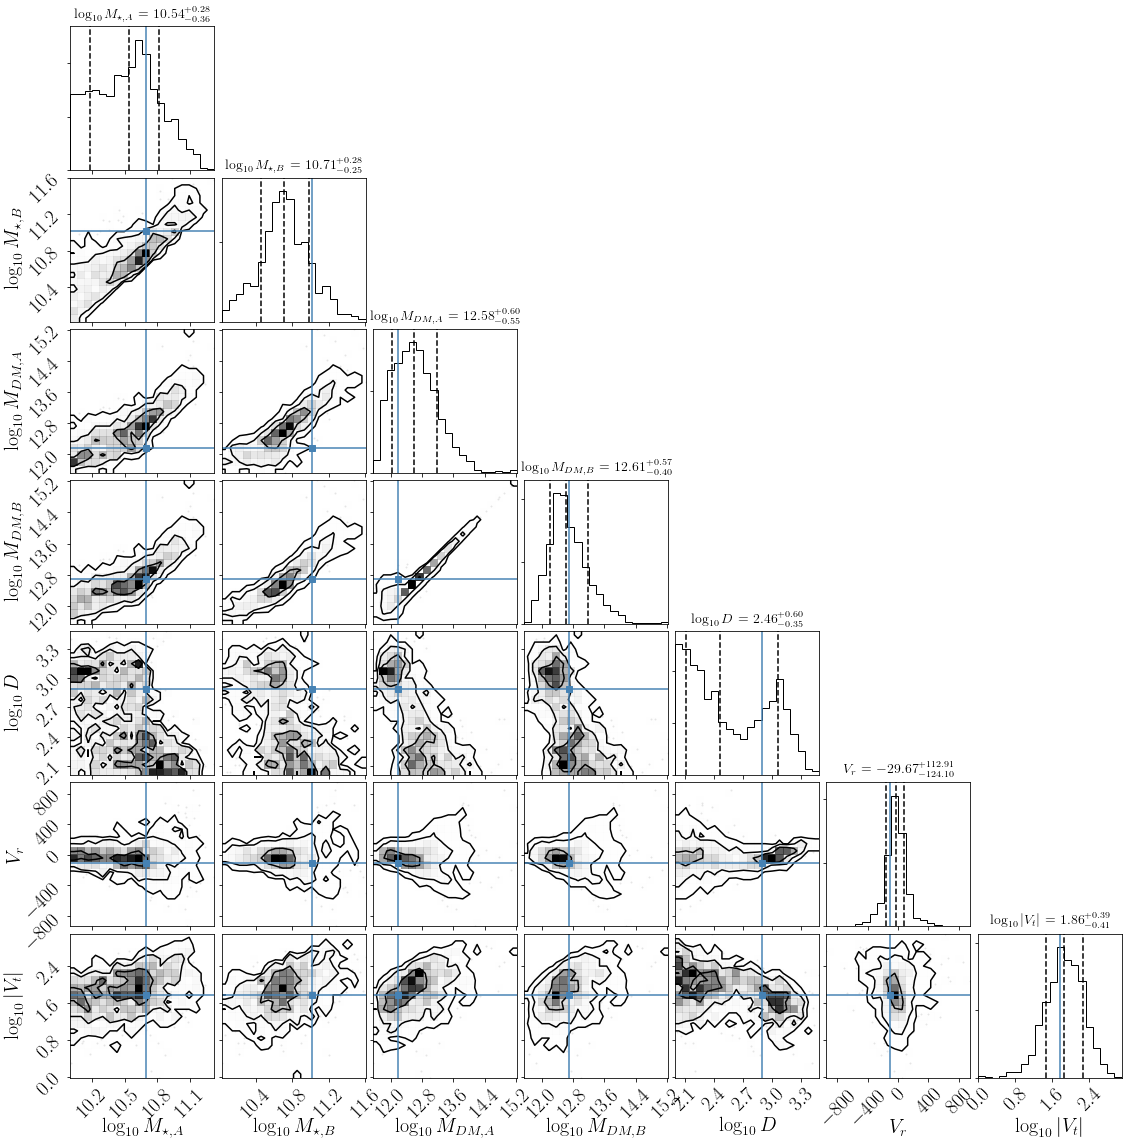

In [698]:
plot_corner_full(pair_data)

In [668]:
def logproba(x, mean_x=6.08E10, sigma_x=1.14E10):
    d = (mean_x - x)/sigma_x
    d = np.exp(-0.5 * (d))
    return d

def integrated_normal_inv(min_x, max_x, n_points, mean_x=5.0E10, sigma_x=1.0E10):
    c = 1/(2.0 * sigma_x ** 2)
    
    q = (min_x-mean_x) 
    min_erf = scipy.special.erf(q * np.sqrt(c))

    q = (max_x-mean_x)
    max_erf = scipy.special.erf(q * np.sqrt(c))
    
    #print(min_erf, max_erf)
    x = np.linspace(min_erf, max_erf, n_points)
    
    y = scipy.special.erfinv(x)/np.sqrt(c) + mean_x
    
    y[np.isinf(y)] = max_x
    return x+1, y
#x, y=integrated_normal_inv(1E10, 10E10, 100)#, mean_x=10, sigma_x=2.0)

#plt.scatter(x, y)
#print(y)

def bootstrap(data, plot=True):
    stellar_mass = data['stellar_mass_A']
    n_points = len(stellar_mass)
    ids = np.ones(n_points, dtype=int)
    
    cdf_grid, mass_grid  = integrated_normal_inv(np.min(stellar_mass), np.max(stellar_mass), n_points)
    for i in range(n_points):
        d = np.abs(stellar_mass-mass_grid[i])
        ids[i] = np.argmin(d)
    if plot:
        plt.hist(stellar_mass[ids], bins=20)
        plt.hist(mass_grid, bins=20, alpha=0.5)
        plot_corner_full(data, id_list=ids, cut_name='star_mass_A')
    return ids

In [669]:
new_ids = bootstrap(pair_data, plot=False)

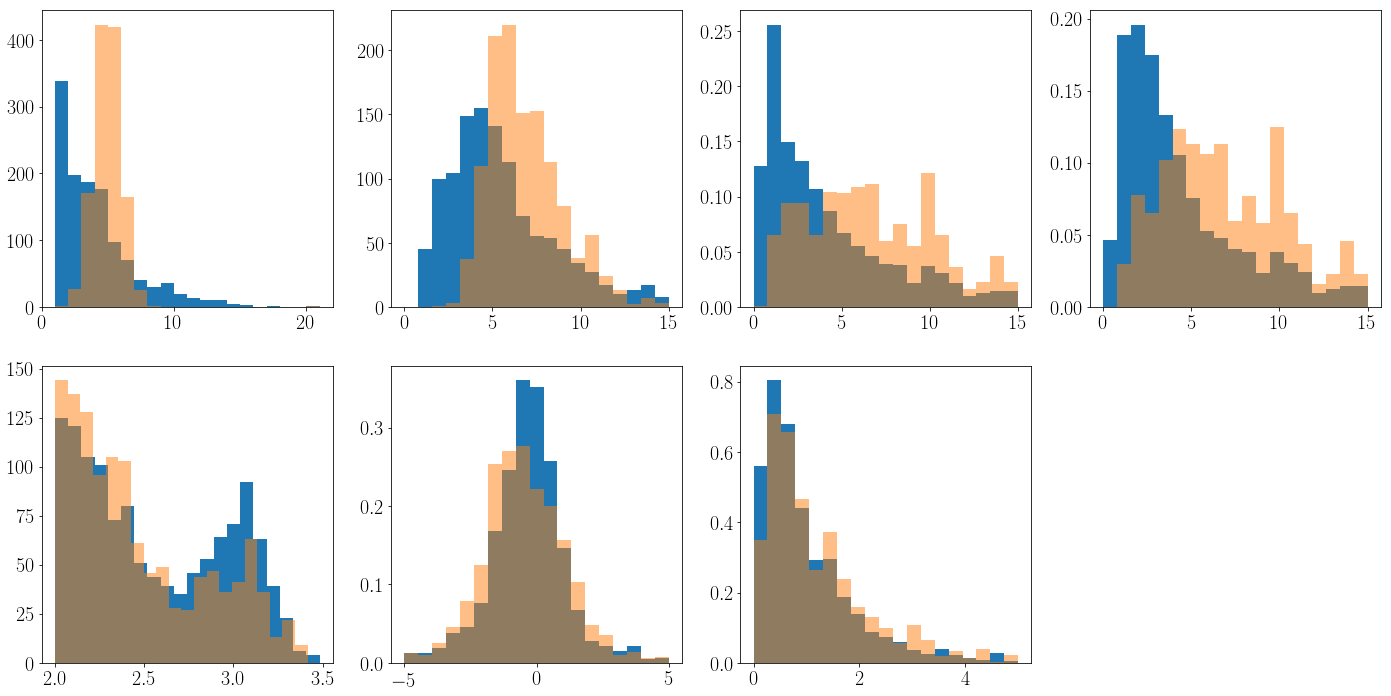

In [670]:
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
_ = plt.hist((pair_data['stellar_mass_A']/1E10), bins=20)
_ = plt.hist((pair_data['stellar_mass_A'][new_ids]/1E10), alpha=0.5, bins=20)

plt.subplot(2,4,2)
_ = plt.hist((pair_data['stellar_mass_B']/1E10), bins=np.linspace(0,15,20))
_ = plt.hist((pair_data['stellar_mass_B'][new_ids]/1E10), alpha=0.5,bins=np.linspace(0,15,20))

plt.subplot(2,4,3)
_ = plt.hist((pair_data['halo_mass_A']/1E12), bins=np.linspace(0,15,20), density=True)
_ = plt.hist((pair_data['halo_mass_A'][new_ids]/1E12), alpha=0.5, bins=np.linspace(0,15,20), density=True)

plt.subplot(2,4,4)
_ = plt.hist((pair_data['halo_mass_B']/1E12), bins=np.linspace(0,15,20), density=True)
_ = plt.hist((pair_data['halo_mass_B'][new_ids]/1E12), alpha=0.5, bins=np.linspace(0,15,20), density=True)

plt.subplot(2,4,5)
_ = plt.hist(np.log10(pair_data['pos_AB']), bins=20)
_ = plt.hist(np.log10(pair_data['pos_AB'][new_ids]), alpha=0.5, bins=20)

plt.subplot(2,4,6)
_ = plt.hist((pair_data['vel_AB_rad']/100), bins=np.linspace(-5,5,20), density=True)
_ = plt.hist((pair_data['vel_AB_rad'][new_ids]/100), bins=np.linspace(-5,5,20),alpha=0.5, density=True)


plt.subplot(2,4,7)
_ = plt.hist((pair_data['vel_AB_tan']/100), bins=np.linspace(0,5,20), density=True)
_ = plt.hist((pair_data['vel_AB_tan'][new_ids]/100), alpha=0.5, bins=np.linspace(0,5,20), density=True)

In [671]:
list_percentiles = {}
for field in ['pos_AB', 'vel_AB_rad', 'vel_AB_tan']:
    percentiles = np.percentile(pair_data[field][new_ids], np.linspace(0,100,101))
    percentile_location = np.ones(len(pair_data[field]))

    for i,v in enumerate(pair_data[field]):
        percentile_location[i] = np.abs(np.argmin(np.abs(percentiles-v))-50.0)
    list_percentiles[field] = percentile_location

5.0990195135927845


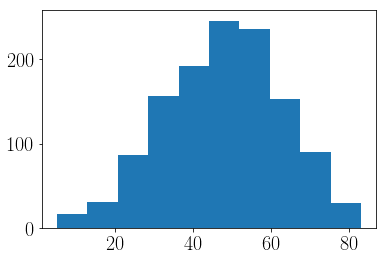

In [672]:
percentile_distance = np.sqrt(list_percentiles['pos_AB']**2 + list_percentiles['vel_AB_rad']**2 + list_percentiles['vel_AB_tan']**2)
_ = plt.hist(percentile_distance)
print(percentile_distance.min())

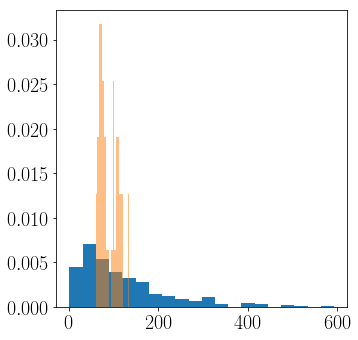

In [673]:
close_ids = percentile_distance<20
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
_ = plt.hist((pair_data['vel_AB_tan'][new_ids]), bins=20, density=True)
_ = plt.hist((pair_data['vel_AB_tan'][close_ids]), alpha=0.5, bins=20, density=True)

In [674]:
filename = '/Users/forero/Illustris_data/WEB_CIC_256_DM_TNG300-2_s1.00.hdf5'
f = h5py.File(filename, 'r')
print(f.keys())
density_smooth_1 = f['density_smooth'][...]
lambda1_1 = f['lambda1'][...]
lambda2_1 = f['lambda2'][...]
lambda3_1 = f['lambda3'][...]
eigen3_1 = f['eigenvector3'][...]
eigen1_1 = f['eigenvector1'][...]

f.close()

<KeysViewHDF5 ['density_smooth', 'eigenvector1', 'eigenvector2', 'eigenvector3', 'hessian', 'lambda1', 'lambda2', 'lambda3', 'potential']>


In [675]:
filename = '/Users/forero/Illustris_data/WEB_CIC_256_DM_TNG300-2_s20.00.hdf5'
f = h5py.File(filename, 'r')
print(f.keys())
density_smooth_20 = f['density_smooth'][...]
lambda1_20 = f['lambda1'][...]
lambda2_20 = f['lambda2'][...]
lambda3_20 = f['lambda3'][...]
eigen3_20 = f['eigenvector3'][...]
eigen1_20 = f['eigenvector1'][...]

f.close()

<KeysViewHDF5 ['density_smooth', 'eigenvector1', 'eigenvector2', 'eigenvector3', 'hessian', 'lambda1', 'lambda2', 'lambda3', 'potential']>


In [676]:
mu_3 = np.abs(np.sum((eigen3_1 * eigen3_20), axis=3))

FA_1 = (1.0/np.sqrt(3.0))*np.sqrt(((lambda1_1-lambda2_1)**2 + (lambda1_1-lambda3_1)**2 + (lambda2_1-lambda3_1)**2)/(lambda1_1**2+lambda2_1**2+lambda3_1**2))

trace_1 = (lambda1_1+lambda2_1+lambda3_1)
trace_1[trace_1<-1.0] = -0.9999999
alpha_1 = np.sqrt(0.5*((lambda1_1-lambda2_1)**2 + (lambda1_1-lambda3_1)**2 + (lambda2_1-lambda3_1)**2))/(trace_1+1)

FA_20 = (1.0/np.sqrt(3.0))*np.sqrt(((lambda1_20-lambda2_20)**2 + (lambda1_20-lambda3_20)**2 + (lambda2_20-lambda3_20)**2)/(lambda1_20**2+lambda2_20**2+lambda3_20**2))

trace_20 = (lambda1_20+lambda2_20+lambda3_20)
trace_20[trace_20<-1.0] = -0.9999999
alpha_20 = np.sqrt(0.5*((lambda1_20-lambda2_20)**2 + (lambda1_20-lambda3_20)**2 + (lambda2_20-lambda3_20)**2))/(trace_20+1)

In [677]:
BoxSize = 205000.0/pair_data['hubble']
delta_box = BoxSize/np.shape(lambda1_1)[0]
ii_box = np.int_(pair_data['pos_G'][:,0]//delta_box)
jj_box = np.int_(pair_data['pos_G'][:,1]//delta_box)
kk_box = np.int_(pair_data['pos_G'][:,2]//delta_box)
mu_3_halo = mu_3[ii_box, jj_box, kk_box]
lambda1_1_halo = lambda1_1[ii_box, jj_box, kk_box]
lambda2_1_halo = lambda2_1[ii_box, jj_box, kk_box]
lambda3_1_halo = lambda3_1[ii_box, jj_box, kk_box]
density_1_halo = density_smooth_1[ii_box, jj_box, kk_box]
alpha_1_halo = alpha_1[ii_box, jj_box, kk_box]
FA_1_halo = FA_1[ii_box, jj_box, kk_box]

In [678]:
BoxSize = 205000.0/pair_data['hubble']
delta_box = BoxSize/np.shape(lambda1_1)[0]
ii_box = np.int_(pair_data['pos_G'][:,0]//delta_box)
jj_box = np.int_(pair_data['pos_G'][:,1]//delta_box)
kk_box = np.int_(pair_data['pos_G'][:,2]//delta_box)
mu_3_halo = mu_3[ii_box, jj_box, kk_box]
lambda1_20_halo = lambda1_20[ii_box, jj_box, kk_box]
lambda2_20_halo = lambda2_20[ii_box, jj_box, kk_box]
lambda3_20_halo = lambda3_20[ii_box, jj_box, kk_box]
density_20_halo = density_smooth_20[ii_box, jj_box, kk_box]
alpha_20_halo = alpha_20[ii_box, jj_box, kk_box]
FA_20_halo = FA_20[ii_box, jj_box, kk_box]


BoxSize = 205000.0/pair_data['hubble']
delta_box = BoxSize/np.shape(lambda1_1)[0]
ii_box = np.int_(pair_data['pos_A'][:,0]//delta_box)
jj_box = np.int_(pair_data['pos_A'][:,1]//delta_box)
kk_box = np.int_(pair_data['pos_A'][:,2]//delta_box)
mu_3_pair = mu_3[ii_box, jj_box, kk_box]
lambda1_20_pair = lambda1_20[ii_box, jj_box, kk_box]
lambda2_20_pair = lambda2_20[ii_box, jj_box, kk_box]
lambda3_20_pair = lambda3_20[ii_box, jj_box, kk_box]
density_20_pair = density_smooth_20[ii_box, jj_box, kk_box]
alpha_20_pair = alpha_20[ii_box, jj_box, kk_box]
FA_20_pair = FA_20[ii_box, jj_box, kk_box]

In [679]:
BoxSize = 205000.0/pair_data['hubble']
delta_box = delta_box = BoxSize/np.shape(lambda1_1)[0]
ii_box = np.int_(pair_data['pos_A'][:,0]//delta_box)
jj_box = np.int_(pair_data['pos_A'][:,1]//delta_box)
kk_box = np.int_(pair_data['pos_A'][:,2]//delta_box)
mu_3_pair = mu_3[ii_box, jj_box, kk_box]
lambda1_1_pair = lambda1_1[ii_box, jj_box, kk_box]
lambda2_1_pair = lambda2_1[ii_box, jj_box, kk_box]
lambda3_1_pair = lambda3_1[ii_box, jj_box, kk_box]
density_1_pair = density_smooth_1[ii_box, jj_box, kk_box]
alpha_1_pair = alpha_1[ii_box, jj_box, kk_box]
FA_1_pair = FA_1[ii_box, jj_box, kk_box]

(-2, 2)

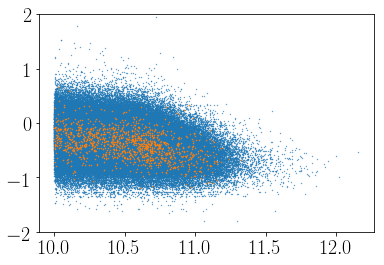

In [680]:
plt.scatter(np.log10(pair_data['stellar_mass_G']), np.log10(alpha_1_halo), s=0.1)
plt.scatter(np.log10(pair_data['stellar_mass_A']), np.log10(alpha_1_pair), s=0.3)

plt.ylim([-2,2])

(-1.5, 0)

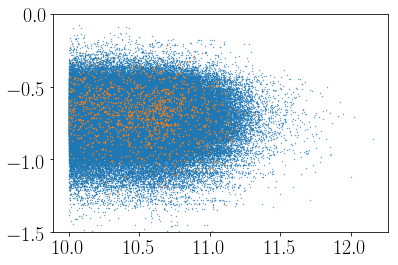

In [681]:
plt.scatter(np.log10(pair_data['stellar_mass_G']), np.log10(alpha_20_halo), s=0.1)
plt.scatter(np.log10(pair_data['stellar_mass_A']), np.log10(alpha_20_pair), s=0.3)

plt.ylim([-1.5,0])

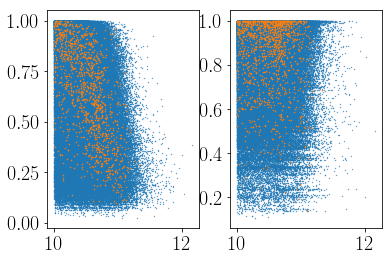

In [682]:
plt.subplot(1,2,1)
plt.scatter(np.log10(pair_data['stellar_mass_G']), (FA_1_halo), s=0.1)
plt.scatter(np.log10(pair_data['stellar_mass_A']), (FA_1_pair), s=0.3)

plt.subplot(1,2,2)
plt.scatter(np.log10(pair_data['stellar_mass_G']), (FA_20_halo), s=0.1)
plt.scatter(np.log10(pair_data['stellar_mass_A']), (FA_20_pair), s=0.3)

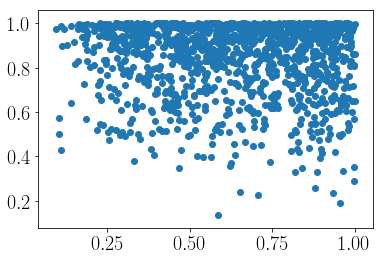

In [683]:
plt.scatter(FA_1_pair, FA_20_pair)

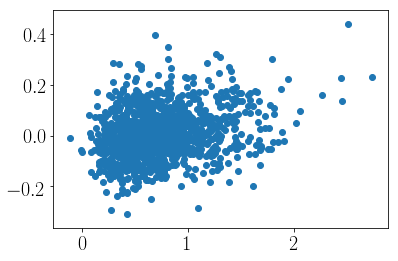

In [684]:
plt.scatter(np.log10(density_1_pair+1), np.log10(density_20_pair+1))

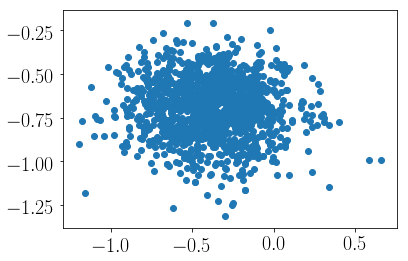

In [685]:
plt.scatter(np.log10(alpha_1_pair), np.log10(alpha_20_pair))

(array([0.80244059, 0.7375969 , 0.94833874, 0.92402263, 0.84296802,
        0.81054593, 1.08613154, 0.99697209, 1.14286976, 1.71835737]),
 array([7.3841214e-04, 1.0063608e-01, 2.0053375e-01, 3.0043143e-01,
        4.0032908e-01, 5.0022674e-01, 6.0012442e-01, 7.0002210e-01,
        7.9991972e-01, 8.9981741e-01, 9.9971509e-01], dtype=float32),
 <a list of 10 Patch objects>)

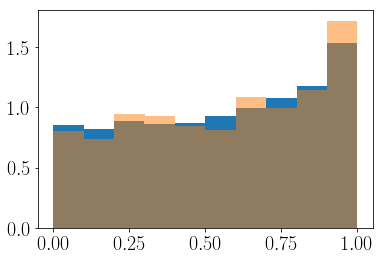

In [686]:
plt.hist(mu_3_halo, density=True)
plt.hist(mu_3_pair, density=True, alpha=0.5)

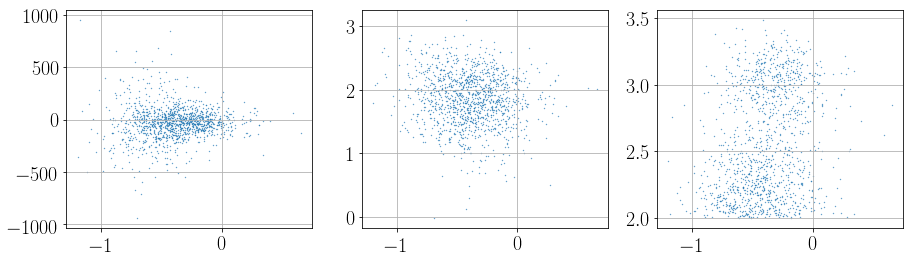

In [687]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(np.log10(alpha_1_pair),pair_data['vel_AB_rad'],  s=0.1)
plt.grid()

plt.subplot(1,3,2)
plt.scatter(np.log10(alpha_1_pair),np.log10(pair_data['vel_AB_tan']),  s=0.1)
plt.grid()

plt.subplot(1,3,3)
plt.scatter(np.log10(alpha_1_pair), np.log10(pair_data['pos_AB']),  s=0.1)
plt.grid()

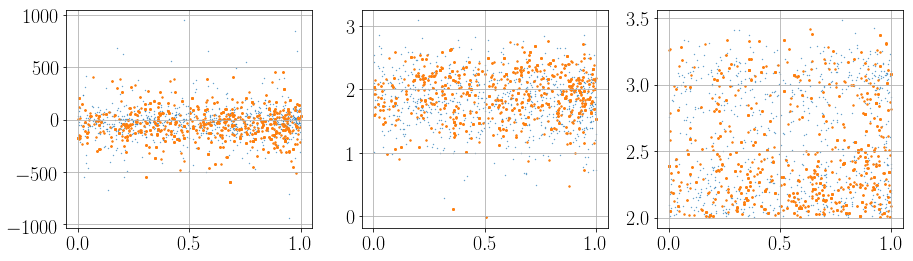

In [688]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter((mu_3_pair),pair_data['vel_AB_rad'], s=0.1)
plt.scatter((mu_3_pair[new_ids]),pair_data['vel_AB_rad'][new_ids], s=2)

plt.grid()

plt.subplot(1,3,2)
plt.scatter((mu_3_pair),np.log10(pair_data['vel_AB_tan']),  s=0.1)
plt.scatter((mu_3_pair[new_ids]),np.log10(pair_data['vel_AB_tan'][new_ids]),  s=2)

plt.grid()

plt.subplot(1,3,3)
plt.scatter((mu_3_pair),np.log10(pair_data['pos_AB']),  s=0.1)
plt.scatter((mu_3_pair[new_ids]),np.log10(pair_data['pos_AB'][new_ids]),  s=2)

plt.grid()

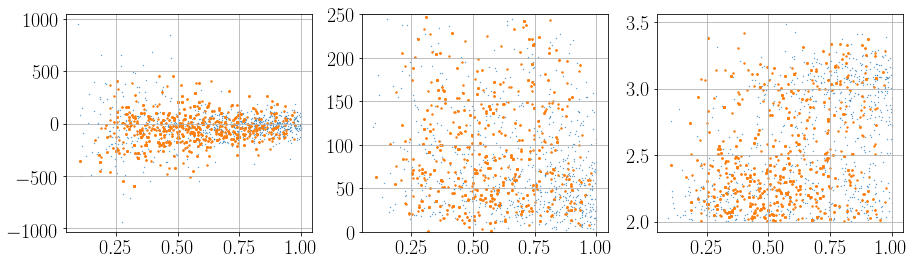

In [689]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter((FA_1_pair),pair_data['vel_AB_rad'], s=0.1)
plt.scatter((FA_1_pair[new_ids]),pair_data['vel_AB_rad'][new_ids], s=2)

plt.grid()

plt.subplot(1,3,2)
plt.scatter((FA_1_pair),(pair_data['vel_AB_tan']),  s=0.1)
plt.scatter((FA_1_pair[new_ids]),(pair_data['vel_AB_tan'][new_ids]), s=2)
plt.ylim([0,250])
plt.grid()

plt.subplot(1,3,3)
plt.scatter((FA_1_pair),np.log10(pair_data['pos_AB']),  s=0.1)
plt.scatter((FA_1_pair[new_ids]),np.log10(pair_data['pos_AB'][new_ids]),  s=2)
plt.grid()

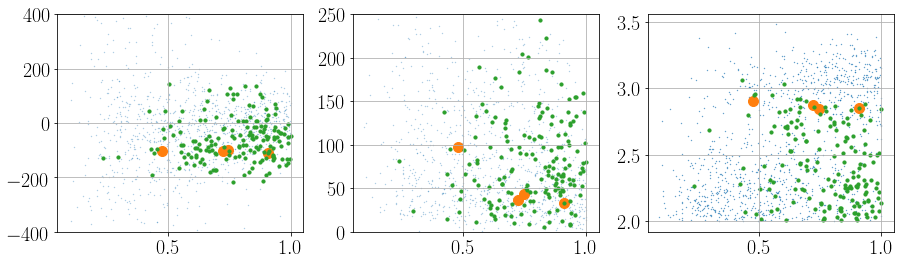

In [690]:
web_data = FA_1_pair.copy()
lg_ids = (pair_data['vel_AB_rad']<-100) & (pair_data['vel_AB_rad']>-120)
lg_ids &= (pair_data['vel_AB_tan']<100) & (pair_data['vel_AB_tan']>0)
lg_ids &= (pair_data['pos_AB']<800) & (pair_data['pos_AB']>700)


#web_ids = (alpha_1_pair<1.0) & (mu_3_pair>0.5) & (FA_1_pair>0.5)
web_ids = (np.log10(density_1_pair+1.0)<0.85) #& (np.log10(density_1_pair+1.0)<0.40) 
#web_ids = density_1_pair>0

select_ids = (pair_data['halo_mass_A']==pair_data['halo_mass_B']) 
select_ids &= (np.log10(pair_data['halo_mass_A'])<12.50)
select_ids &= (np.log10(pair_data['halo_mass_A'])>12.10)


plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter((web_data),pair_data['vel_AB_rad'], s=0.1, alpha=0.5)
plt.scatter((web_data[lg_ids]),pair_data['vel_AB_rad'][lg_ids], s=100)
plt.scatter((web_data[select_ids&web_ids]),pair_data['vel_AB_rad'][select_ids&web_ids], s=10)
plt.ylim([-400,400])


plt.grid()

plt.subplot(1,3,2)
plt.scatter((web_data),(pair_data['vel_AB_tan']),  s=0.1, alpha=0.5)
plt.scatter((web_data[lg_ids]),(pair_data['vel_AB_tan'][lg_ids]), s=100)
plt.scatter((web_data[select_ids&web_ids]),pair_data['vel_AB_tan'][select_ids&web_ids], s=10)
plt.ylim([0,250])
plt.grid()

plt.subplot(1,3,3)
plt.scatter((web_data),np.log10(pair_data['pos_AB']),  s=0.1)
plt.scatter((web_data[lg_ids]),np.log10(pair_data['pos_AB'][lg_ids]),  s=100)
plt.scatter((web_data[select_ids&web_ids]),np.log10(pair_data['pos_AB'][select_ids&web_ids]),  s=10)

plt.grid()

In [691]:
print(pair_data['pos_A'][lg_ids]*pair_data['hubble'])

[[ 24131.479 203657.7   177222.7  ]
 [149992.53   19268.71  112934.32 ]
 [ 88993.62  183283.95  124383.93 ]
 [146630.1   153608.44  140215.25 ]]


12.30236
0.21002276
10.508524660925485
0.17328758919514228


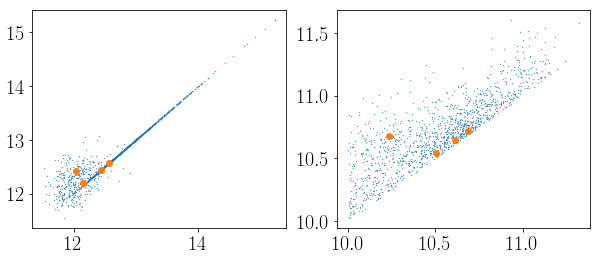

In [692]:
#ii = (pair_data['vel_AB_rad']<0.0) & (pair_data['vel_AB_tan']<100)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(np.log10(pair_data['halo_mass_A']), np.log10(pair_data['halo_mass_B']), s=0.1)
plt.scatter(np.log10(pair_data['halo_mass_A'][lg_ids]), np.log10(pair_data['halo_mass_B'][lg_ids]))
print(np.mean(np.log10(pair_data['halo_mass_A'][lg_ids])))
print(np.std(np.log10(pair_data['halo_mass_A'][lg_ids])))


plt.subplot(1,2,2)
plt.scatter(np.log10(pair_data['stellar_mass_A']), np.log10(pair_data['stellar_mass_B']), s=0.1)
plt.scatter(np.log10(pair_data['stellar_mass_A'][lg_ids]), np.log10(pair_data['stellar_mass_B'][lg_ids]))
print(np.mean(np.log10(pair_data['stellar_mass_A'][lg_ids])))
print(np.std(np.log10(pair_data['stellar_mass_A'][lg_ids])))


12.30236
0.21002276
10.508524660925485
0.17328758919514228


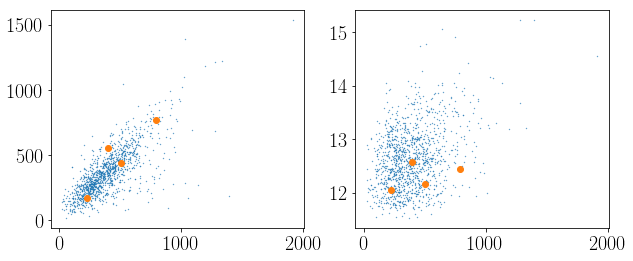

In [693]:
#ii = (pair_data['vel_AB_rad']<0.0) & (pair_data['vel_AB_tan']<100)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter((pair_data['vel_A_mag']), (pair_data['vel_B_mag']), s=0.1)
plt.scatter((pair_data['vel_A_mag'][lg_ids]), (pair_data['vel_B_mag'][lg_ids]))
print(np.mean(np.log10(pair_data['halo_mass_A'][lg_ids])))
print(np.std(np.log10(pair_data['halo_mass_A'][lg_ids])))


plt.subplot(1,2,2)
plt.scatter((pair_data['vel_A_mag']), np.log10(pair_data['halo_mass_A']), s=0.1)
plt.scatter((pair_data['vel_A_mag'][lg_ids]), np.log10(pair_data['halo_mass_A'][lg_ids]))
print(np.mean(np.log10(pair_data['stellar_mass_A'][lg_ids])))
print(np.std(np.log10(pair_data['stellar_mass_A'][lg_ids])))


12.30236
0.21002276


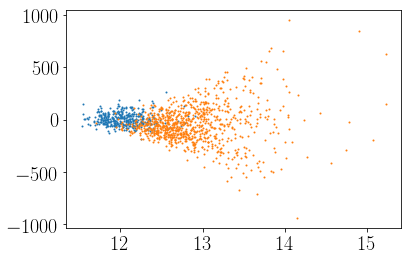

In [694]:
#ii = (pair_data['vel_AB_rad']<0.0) & (pair_data['vel_AB_tan']<100)
ll = pair_data['halo_mass_A']==pair_data['halo_mass_B']
plt.scatter(np.log10(pair_data['halo_mass_A'][~ll]), (pair_data['vel_AB_rad'][~ll]), s=1.0)

plt.scatter(np.log10(pair_data['halo_mass_A'][ll]), (pair_data['vel_AB_rad'][ll]), s=1.0)
#plt.ylim([-120,-100])
#plt.scatter(np.log10(pair_data['halo_mass_A'][lg_ids]), np.log10(pair_data['halo_mass_B'][lg_ids]))
print(np.mean(np.log10(pair_data['halo_mass_A'][lg_ids])))
print(np.std(np.log10(pair_data['halo_mass_A'][lg_ids])))

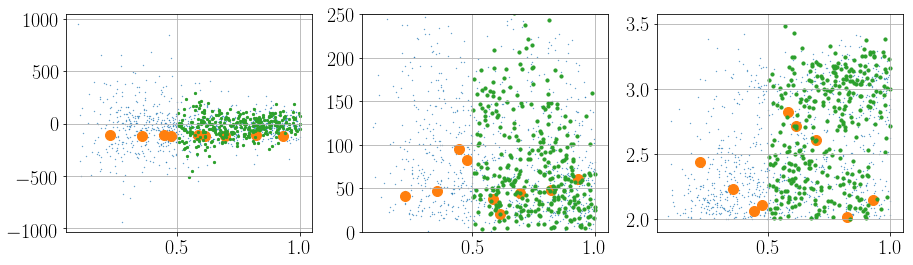

In [695]:
web_data = FA_1_pair
lg_ids = (pair_data['vel_AB_rad']<-110) & (pair_data['vel_AB_rad']>-120)
lg_ids &= (pair_data['vel_AB_tan']<100)
lg_ids &= (pair_data['pos_AB']<700)

web_ids = (alpha_1_pair<1) & (mu_3_pair>0.5) & (FA_1_pair>0.5)
web_ids &= (FA_20_pair>0.8)


plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter((web_data),pair_data['vel_AB_rad'], s=0.1)
plt.scatter((web_data[lg_ids]),pair_data['vel_AB_rad'][lg_ids], s=100)
plt.scatter((web_data[web_ids]),pair_data['vel_AB_rad'][web_ids], s=5)


plt.grid()

plt.subplot(1,3,2)
plt.scatter((web_data),(pair_data['vel_AB_tan']),  s=0.1)
plt.scatter((web_data[lg_ids]),(pair_data['vel_AB_tan'][lg_ids]), s=100)
plt.scatter((web_data[web_ids]),pair_data['vel_AB_tan'][web_ids], s=10)
plt.ylim([0,250])
plt.grid()

plt.subplot(1,3,3)
plt.scatter((web_data),np.log10(pair_data['pos_AB']),  s=0.1)
plt.scatter((web_data[lg_ids]),np.log10(pair_data['pos_AB'][lg_ids]),  s=100)
plt.scatter((web_data[web_ids]),np.log10(pair_data['pos_AB'][web_ids]),  s=10)

plt.grid()

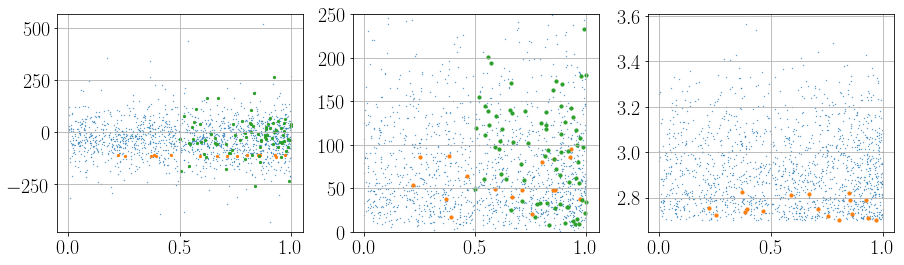

In [484]:
web_data = mu_3_pair.copy()
lg_ids = (pair_data['vel_AB_rad']<-110) & (pair_data['vel_AB_rad']>-120)
lg_ids &= (pair_data['vel_AB_tan']<100)
lg_ids &= (pair_data['pos_AB']<700)

web_ids = (alpha_1_pair>1) & (mu_3_pair>0.5) & (FA_1_pair>0.5) & (np.log10(density_1_pair + 1.0) > 0.5)


plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter((web_data),pair_data['vel_AB_rad'], s=0.1)
plt.scatter((web_data[lg_ids]),pair_data['vel_AB_rad'][lg_ids], s=5)
plt.scatter((web_data[web_ids]),pair_data['vel_AB_rad'][web_ids], s=5)


plt.grid()

plt.subplot(1,3,2)
plt.scatter((web_data),(pair_data['vel_AB_tan']),  s=0.1)
plt.scatter((web_data[lg_ids]),(pair_data['vel_AB_tan'][lg_ids]), s=10)
plt.scatter((web_data[web_ids]),pair_data['vel_AB_tan'][web_ids], s=10)
plt.ylim([0,250])
plt.grid()

plt.subplot(1,3,3)
plt.scatter((web_data),np.log10(pair_data['pos_AB']),  s=0.1)
plt.scatter((web_data[lg_ids]),np.log10(pair_data['pos_AB'][lg_ids]),  s=10)
plt.grid()

0.73139596 0.34239203


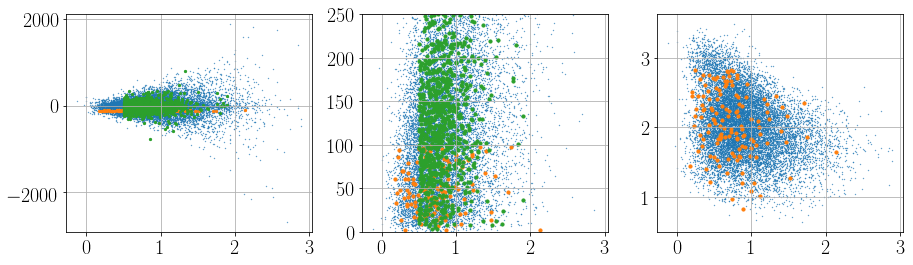

In [544]:
web_data = np.log10(density_1_pair+1.0)
lg_ids = (pair_data['vel_AB_rad']<-110) & (pair_data['vel_AB_rad']>-120)
lg_ids &= (pair_data['vel_AB_tan']<100)
lg_ids &= (pair_data['pos_AB']<700)

web_ids = (alpha_1_pair>1) & (mu_3_pair>0.5) & (FA_1_pair>0.5) & (np.log10(density_1_pair + 1.0) > 0.5)


plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter((web_data),pair_data['vel_AB_rad'], s=0.1)
plt.scatter((web_data[lg_ids]),pair_data['vel_AB_rad'][lg_ids], s=5)
plt.scatter((web_data[web_ids]),pair_data['vel_AB_rad'][web_ids], s=5)


plt.grid()

plt.subplot(1,3,2)
plt.scatter((web_data),(pair_data['vel_AB_tan']),  s=0.1)
plt.scatter((web_data[lg_ids]),(pair_data['vel_AB_tan'][lg_ids]), s=10)
plt.scatter((web_data[web_ids]),pair_data['vel_AB_tan'][web_ids], s=10)
plt.ylim([0,250])
plt.grid()

plt.subplot(1,3,3)
plt.scatter((web_data),np.log10(pair_data['pos_AB']),  s=0.1)
plt.scatter((web_data[lg_ids]),np.log10(pair_data['pos_AB'][lg_ids]),  s=10)
plt.grid()
print(np.mean(web_data[lg_ids]), np.std(web_data[lg_ids]))

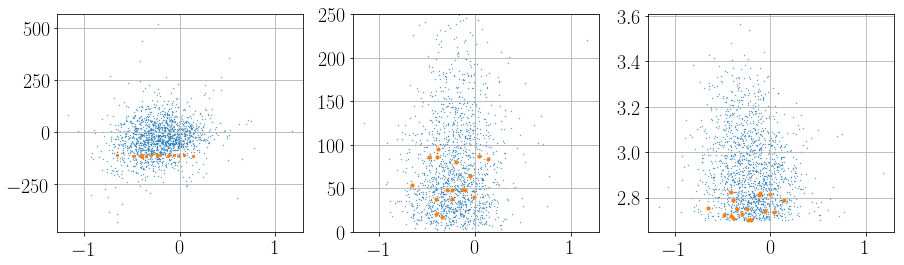

In [243]:
web_data = np.log10(alpha_1_pair)
lg_ids = (pair_data['vel_AB_rad']<-110) & (pair_data['vel_AB_rad']>-120)
lg_ids &= (pair_data['vel_AB_tan']<100)
lg_ids &= (pair_data['pos_AB']<700)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter((web_data),pair_data['vel_AB_rad'], s=0.1)
plt.scatter((web_data[lg_ids]),pair_data['vel_AB_rad'][lg_ids], s=5)

plt.grid()

plt.subplot(1,3,2)
plt.scatter((web_data),(pair_data['vel_AB_tan']),  s=0.1)
plt.scatter((web_data[lg_ids]),(pair_data['vel_AB_tan'][lg_ids]), s=10)
plt.ylim([0,250])
plt.grid()

plt.subplot(1,3,3)
plt.scatter((web_data),np.log10(pair_data['pos_AB']),  s=0.1)
plt.scatter((web_data[lg_ids]),np.log10(pair_data['pos_AB'][lg_ids]),  s=10)
plt.grid()